In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
# Custom callback to evaluate test accuracy after each epoch
class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(self.test_data, verbose=0)
        self.test_accuracy.append(test_acc)
        print(f'\nTest Accuracy after epoch {epoch + 1}: {test_acc:.4f}')

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the dataset directory
original_dataset_dir = r'C:\Users\Dell\Desktop\ga\IMG Classification\original_data'

# Define directories for train, test, and validation data
output_base_dir = r"C:\Users\Dell\Desktop\ga\IMG Classification"
train_dir = os.path.join(output_base_dir, "train")
test_dir = os.path.join(output_base_dir, "test")
val_dir = os.path.join(output_base_dir, "val")

# Create train, test, and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get list of class names (subdirectories) in the dataset directory
class_names = [d for d in os.listdir(original_dataset_dir) if os.path.isdir(os.path.join(original_dataset_dir, d))]

# Iterate over each class
for class_name in class_names:
    class_path = os.path.join(original_dataset_dir, class_name)
    
    # Get list of image filenames for the current class
    class_images = os.listdir(class_path)
    
    # Split the images into train, test, and validate sets
    train_images, test_val_images = train_test_split(class_images, test_size=0.2, random_state=42)
    test_images, val_images = train_test_split(test_val_images, test_size=0.5, random_state=42)
    
    # Move images to respective directories
    for image in train_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(val_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset splitting completed successfully.")


Dataset splitting completed successfully.


In [20]:
# Define image size and batch size
image_size = (150, 150)
batch_size = 16

# Image data generators for loading and augmenting the images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train and test datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 652 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [22]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define callbacks
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='accuracy', save_best_only=True, mode='max', verbose=1)
test_accuracy_callback = TestAccuracyCallback(test_generator)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[model_checkpoint, test_accuracy_callback]
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6907 - loss: 0.5964
Epoch 1: accuracy improved from -inf to 0.81902, saving model to best_model.keras

Test Accuracy after epoch 1: 0.5375
41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6938 - loss: 0.5918 - val_accuracy: 0.5625 - val_loss: 0.8242
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8907 - loss: 0.3031
Epoch 2: accuracy improved from 0.81902 to 0.92331, saving model to best_model.keras

Test Accuracy after epoch 2: 0.9625
41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8914 - loss: 0.3013 - val_accuracy: 0.9875 - val_loss: 0.1145
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9623 - loss: 0.1301
Epoch 3: accuracy improved from 0.92331 to 0.95859, saving model to best_model.keras

Test Accuracy after epoch 3: 1.0000
41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9623 - loss: 0.1300 - val_accuracy: 0.9875 - val_loss: 0.0366
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 91

In [24]:
average_test_accuracy = np.mean(test_accuracy_callback.test_accuracy)
print(f'Average Test Accuracy: {average_test_accuracy:.4f}')

Average Test Accuracy: 0.9481


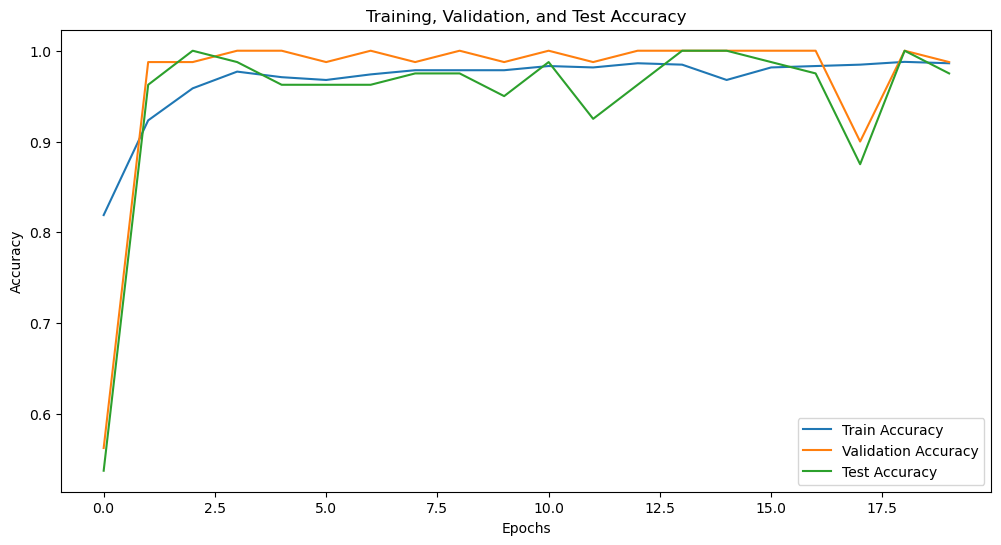

In [25]:
import matplotlib.pyplot as plt
# Plot training, validation, and test accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(test_accuracy_callback.test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [28]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = r'C:\Users\Dell\Desktop\ga\IMG Classification\best_model.keras'  # Update with your model path
model = load_model(model_path)

# Assuming a binary classification, update class_names for multi-class
class_names = ['Chest X-Ray', 'Random Image']  # Update with your actual class names

def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path, target_size=(150, 150))  # Use the same target size as your model input
    prediction = model.predict(img_array)
    predicted_class = class_names[int(prediction[0] > 0.5)]  # Adjust threshold as per your requirement
    return prediction, predicted_class

# Example usage
img_path = input('Enter the path to your image: ')  # Get the path to the image you want to predict
prediction, predicted_class = predict_image(img_path)
print(f'Prediction: {prediction}')
print(f'Predicted class: {predicted_class}')


Enter the path to your image: C:\Users\Dell\Downloads\cvbn1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Prediction: [[4.836303e-06]]
Predicted class: Chest X-Ray
